In [ ]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
import time
import seaborn as sns
warnings.filterwarnings("ignore")

In [ ]:
# First, all available KuCoin Symbols are fetched
url = "https://api.kucoin.com/api/v2/symbols"

payload={}
headers = {}

response = requests.request("GET", url, headers=headers, data=payload)
response_dict = response.text
response_dict = json.loads(response_dict)
print(response_dict["data"][0]["symbol"])

AVA-USDT


In [ ]:
# Based on all KuCoin Symbols, the relevants one are filtered
symbols = [symbol["symbol"] for symbol in response_dict["data"]]
relevant_symbols = [symbol for symbol in symbols if symbol.endswith("USDT")]
relevant_symbols = [symbol for symbol in relevant_symbols if not symbol.endswith(("3S-USDT", "3L-USDT", "DOWN-USDT",
                                                                                 "UP-USDT", "2L-USDT", "2S-USDT", "USDC-USDT",
                                                                                  "USDT-USDC", "TUSD-USDT"))]

print(relevant_symbols[0])

AVA-USDT


In [ ]:
# Fuction to download the historical data from the KuCoin-Api.
# Features per Coin are directly calculated and transformed.
# At the End one large DataFrame in longformat is created

start_time_download = time.time()
def data_download_kucoin(symbol, start, end):

    start_date = pd.Timestamp(start)
    end_date = pd.Timestamp(end)

    start_date = int(datetime.timestamp(start_date))
    end_date = int(datetime.timestamp(end_date))

    dfs = []
    for coin in symbol:
        url_klines = f"https://api.kucoin.com/api/v1/market/candles?symbol={coin}&type=1day&startAt={start_date}&endAt={end_date}"
        payload={}
        headers={}
        response_symbol = requests.request("GET", url_klines, headers=headers, data=payload)
        asset = response_symbol.text
        asset = json.loads(asset)



        asset_list = asset["data"]
        asset_df = pd.DataFrame(asset_list, columns=["open_time", "open", "close", "high", "low", "transactions", "transaction_volume"])
        asset_df = asset_df.set_index("open_time")
        asset_df.index = pd.to_datetime(asset_df.index, unit="s")
        asset_df = asset_df.astype(float)
        asset_df["ticker"] = coin
        asset_df = asset_df[["ticker", "open", "close", "high", "low", "transactions", "transaction_volume"]]
        asset_df = asset_df.iloc[::-1]

        # Transaction volume needs to be shifted forward, because the open is
        # used here. If this is not done, the whole trading volume for the current
        # day would be alligned with the opening --> lookahead bias
        asset_df["transaction_volume"] = asset_df["transaction_volume"].shift()

        asset_df["return"] = asset_df["open"].pct_change()

        asset_df["normalized_open"] = (asset_df["open"] - asset_df["open"].rolling(30).mean()) / asset_df["open"].rolling(30).std()

        asset_df["return_forward"] = asset_df["return"].shift(-1)
        asset_df["return_forward_5"] = asset_df["return"].shift(-5)
        asset_df["return_forward_10"] = asset_df["return"].shift(-10)

        asset_df["momentum_7"] = asset_df["open"].pct_change(7)
        asset_df["momentum_7_scaled"] = ((asset_df["momentum_7"] - asset_df["momentum_7"].rolling(7).mean())
                                        / asset_df["momentum_7"].rolling(7).std())


        asset_df["momentum_20"] = asset_df["open"].pct_change(20)
        asset_df["momentum_20_scaled"] = ((asset_df["momentum_20"] - asset_df["momentum_20"].rolling(20).mean())
                                         / asset_df["momentum_20"].rolling(20).std())

        asset_df["momentum_30"] = asset_df["open"].pct_change(30)
        asset_df["momentum_30_scaled"] = ((asset_df["momentum_30"] - asset_df["momentum_30"].rolling(30).mean())
                                         / asset_df["momentum_30"].rolling(30).std())


        asset_df["momentum_divergence_0730"] = (asset_df["momentum_7_scaled"] + asset_df["momentum_30_scaled"])
        asset_df["momentum_divergence_2030"] = (asset_df["momentum_20_scaled"] + asset_df["momentum_30_scaled"])

        asset_df["moving_average_30_price_ratio"] = asset_df["open"] / asset_df["open"].rolling(30).mean()
        asset_df["moving_average_40_price_ratio"] = asset_df["open"] / asset_df["open"].rolling(40).mean()

        asset_df["moving_average_30_price_ratio_scaled"] = ((asset_df["moving_average_30_price_ratio"]
                                                             - asset_df["moving_average_30_price_ratio"].rolling(30).mean())
                                                            / (asset_df["moving_average_30_price_ratio"].rolling(30).std()))

        asset_df["moving_average_40_price_ratio_scaled"] = ((asset_df["moving_average_40_price_ratio"]
                                                             - asset_df["moving_average_40_price_ratio"].rolling(40).mean())
                                                            / (asset_df["moving_average_40_price_ratio"].rolling(40).std()))

        asset_df["avg_volume"] = asset_df["transaction_volume"].rolling(30).mean()

        asset_df = asset_df.dropna()

        if len(asset_df) != 0:

          dfs.append(asset_df)

    return dfs

prices_list = data_download_kucoin(relevant_symbols, "2019-10-01", "2024-12-31")
end_time_download = time.time()

print(f"Dauer des Downloads: {end_time_download-start_time_download}")

# Concat all dfs to one large df in longformat
cross_df = pd.concat(prices_list, axis = 0)

Dauer des Downloads: 276.0496151447296


In [ ]:
# Reducing the Universe to a top 100 based on the average trading volume
# Other ranking criteria can also be implemented like market-cap or volatility
# The Volume based approach is not a guarantee for survivorship free data

universe = 100
cross_df_universe = cross_df.copy()
cross_df_universe["ranking"] = cross_df_universe.groupby("open_time")["avg_volume"].rank("dense", ascending=False)
cross_df_universe["is_universe"] = cross_df_universe["ranking"] <= universe


# Reducing now
cross_df_universe = cross_df_universe[cross_df_universe["is_universe"] == True]
cross_df_universe["universe_market_mean_return"] = cross_df_universe.groupby("open_time")["return"].transform("mean")
cross_df_universe["demeaned_ticker_return_universe"] = (cross_df_universe["return"]
                                                        - cross_df_universe["universe_market_mean_return"])


# Deciles binning of the features for the whole universe
all_columns = set(list(cross_df_universe.columns))
exclude_columns = set(["ticker", "ranking", "universe_market_mean_return", "is_universe"])
features_uni = all_columns - exclude_columns

for feature in features_uni:
  cross_df_universe[f"{feature}_decile"] = (cross_df_universe.groupby("open_time")[feature]
                                            .transform(lambda x: pd.qcut(x, 10, labels = False)))

In [ ]:
# Function to groupby feature-deciles and get the average forward return
# Plot of the deciles as bar plots to compare the average forward return

# Later: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/figure_title.html

def group_by_decile_and_plot(df, features, ret_forward):

  if len(features) == 2:
    feature_decile_1 = features[0]
    feature_decile_2 = features[1]

    feature_1 = df.groupby(feature_decile_1)[ret_forward].mean()
    feature_2 = df.groupby(feature_decile_2)[ret_forward].mean()

    fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))
    ax1.bar(feature_1.index, feature_1)
    ax1.set_title(feature_decile_1, loc="right", fontsize=12)
    ax1.set_xlabel("Deciles", loc="left")
    ax2.set_ylabel("avg_forward_ret")

    ax2.bar(feature_1.index, feature_2)
    ax2.set_title(feature_decile_2, loc="right", fontsize=12)
    ax2.set_xlabel("Deciles", loc="left")
    ax2.set_ylabel("avg_forward_ret")

  else:
    feature_1 = df.groupby(features[0])[ret_forward].mean()


    plt.figure(figsize=(8,6))
    plt.bar(feature_1.index, feature_1)
    plt.title(features[0])
    plt.xlabel("Deciles")
    plt.ylabel("avg_forward_ret")

  return plt.show()

Now the Deciles will be analysed. The goal is to find a pattern in the returns, conditioned on the cross-sectional binning. So all deciles and the corresponding avg. forward return will be plotted.

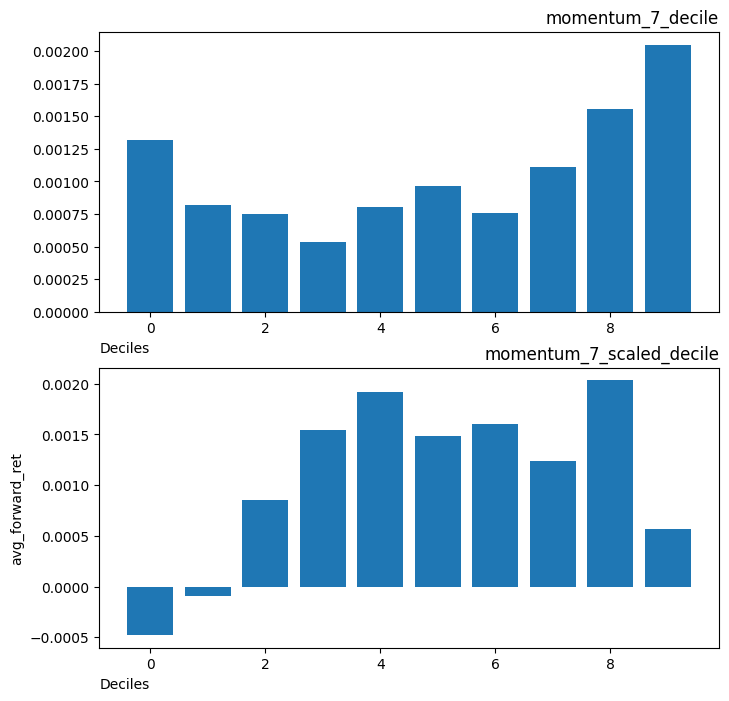

In [ ]:
# Comparing the Features in the cross-section
# First unscaled and scaled features

# Momentum 7

group_by_decile_and_plot(cross_df_universe, ["momentum_7_decile", "momentum_7_scaled_decile"], "return_forward")

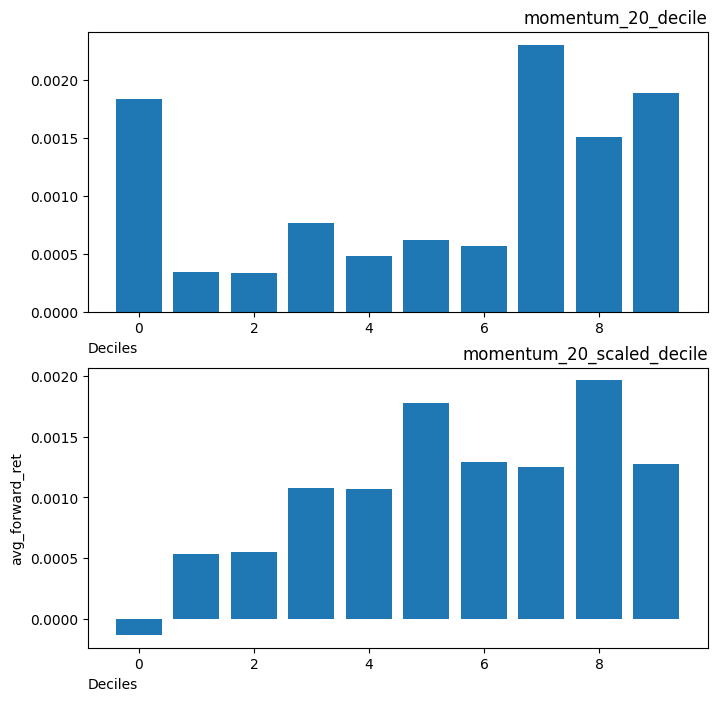

In [ ]:
# Momentum 20

group_by_decile_and_plot(cross_df_universe, ["momentum_20_decile", "momentum_20_scaled_decile"], "return_forward")

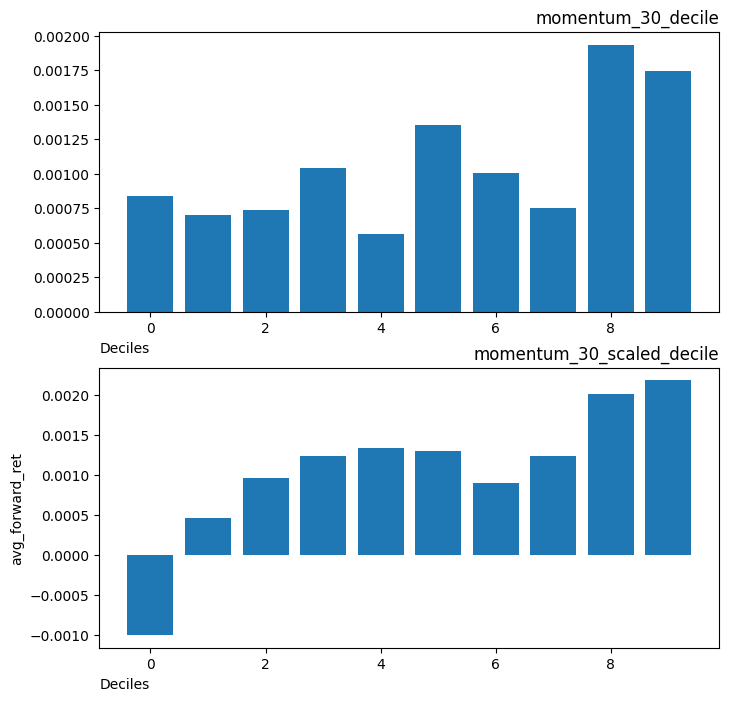

In [ ]:
# Momentum 30

group_by_decile_and_plot(cross_df_universe, ["momentum_30_decile", "momentum_30_scaled_decile"], "return_forward")

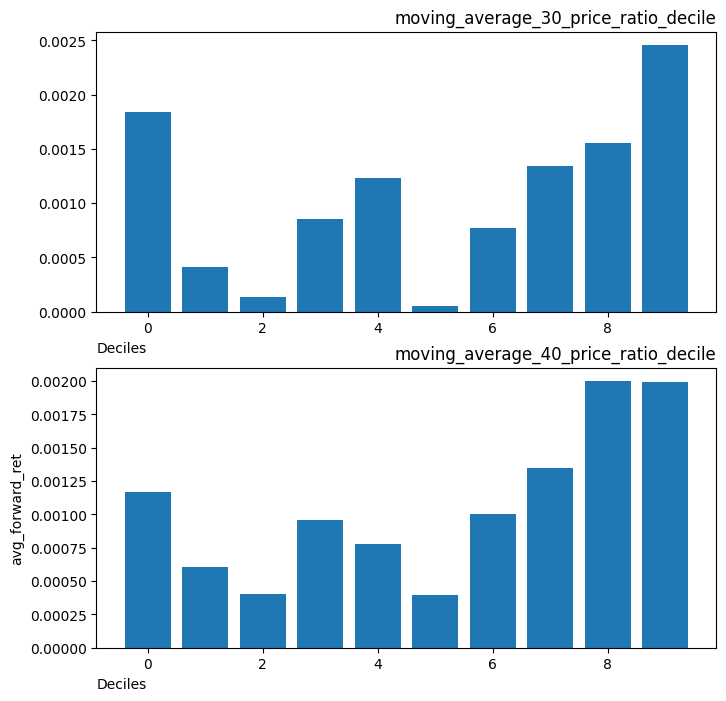

In [ ]:
# Comparing the MA-Ratios
# Like before, first unscaled, than scaled

(group_by_decile_and_plot(cross_df_universe,
                          ["moving_average_30_price_ratio_decile", "moving_average_40_price_ratio_decile"],
                          "return_forward"))

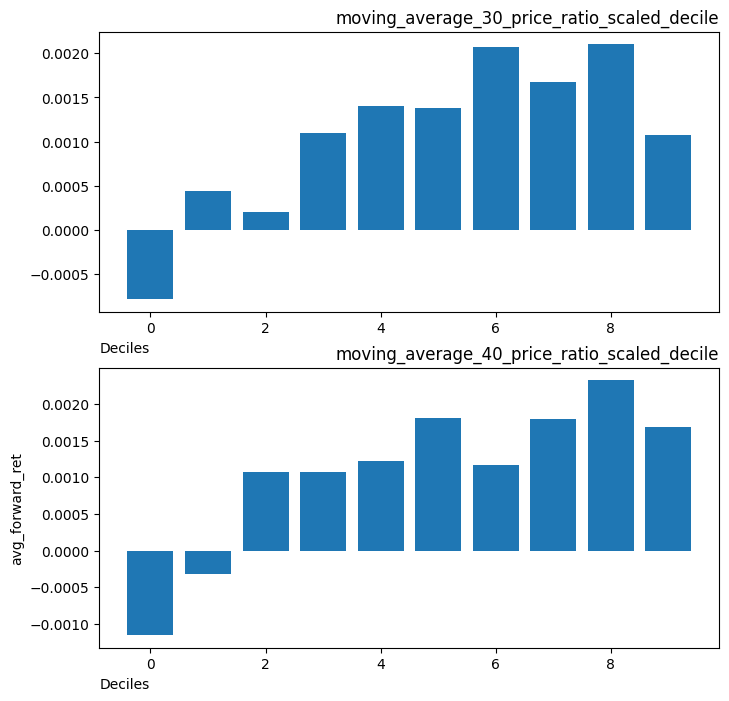

In [ ]:
# Scaled MA-Ratios

(group_by_decile_and_plot(cross_df_universe,
                          ["moving_average_30_price_ratio_scaled_decile", "moving_average_40_price_ratio_scaled_decile"],
                          "return_forward"))

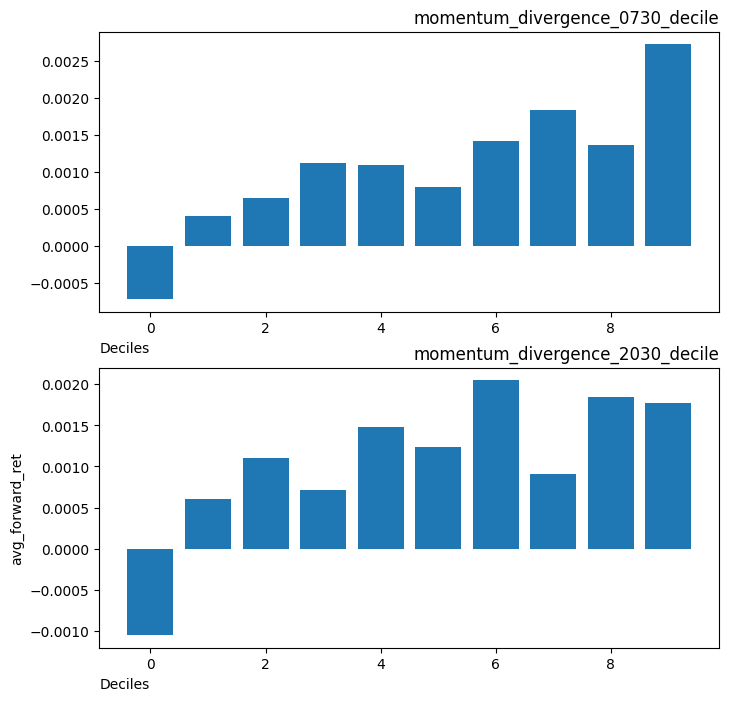

In [ ]:
# Comparing Momentum-Divergence

group_by_decile_and_plot(cross_df_universe, ["momentum_divergence_0730_decile", "momentum_divergence_2030_decile"], "return_forward")

Raw Features or untransformed features did not show a clear pattern.
Sure, the top decile on all untransformed features is showing positive average returns. But after the transformation or z-score normalisation the top and bottom decile is showing exactly the pattern for a market neutral cross sectional momentum strategy. "Buying winners, selling losers". The point in time comparison is also better in terms like: "On any given day, which coin is more away from its own average and hence has momentum?".

The "momentum_divergence_0730" feature shows the greatest avg. return in the top decile with a negative avg. return in the bottom. For the further analysis, this feature will be the main feature.

In the next step, the main feature and additional features are plotted in scatter plots.

Questions, which will be answered:
- Is there any clear linear relationship between the z-scores from the top and bottom decile with the forward return?
- Are the additional features good in describing the relationship between the scores and the forward return?

In [ ]:
# Function, to create a scatter plot
# First filtering based on top or bottom decile
# Relevant to get a clearer picture from the relationship and the possible
# linear relationship (also to understand the behavior like top decile, negative
# z-scores and how the forward return behave in this cases)
# Plotting with an additionally category

def filter_df_and_plot_scatter(df, feature, feature_decile, decile, forward_return, category, pos):

  filtered_df = df.loc[df[feature_decile] == decile]

  return sns.scatterplot(data=filtered_df, x=feature, y=forward_return, hue=category, palette="deep", ax=pos)

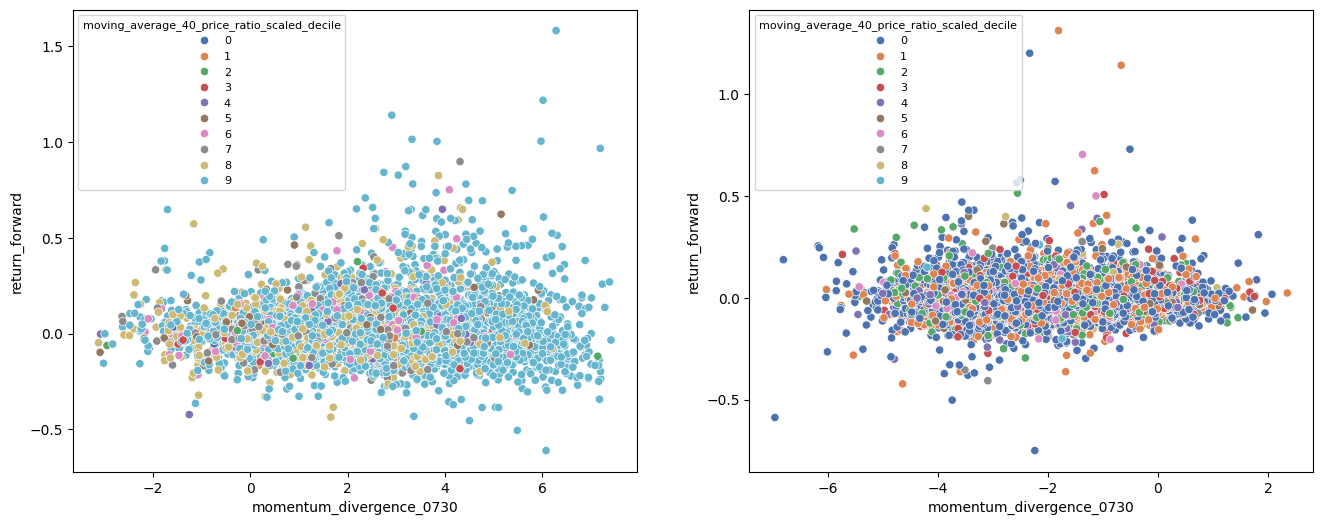

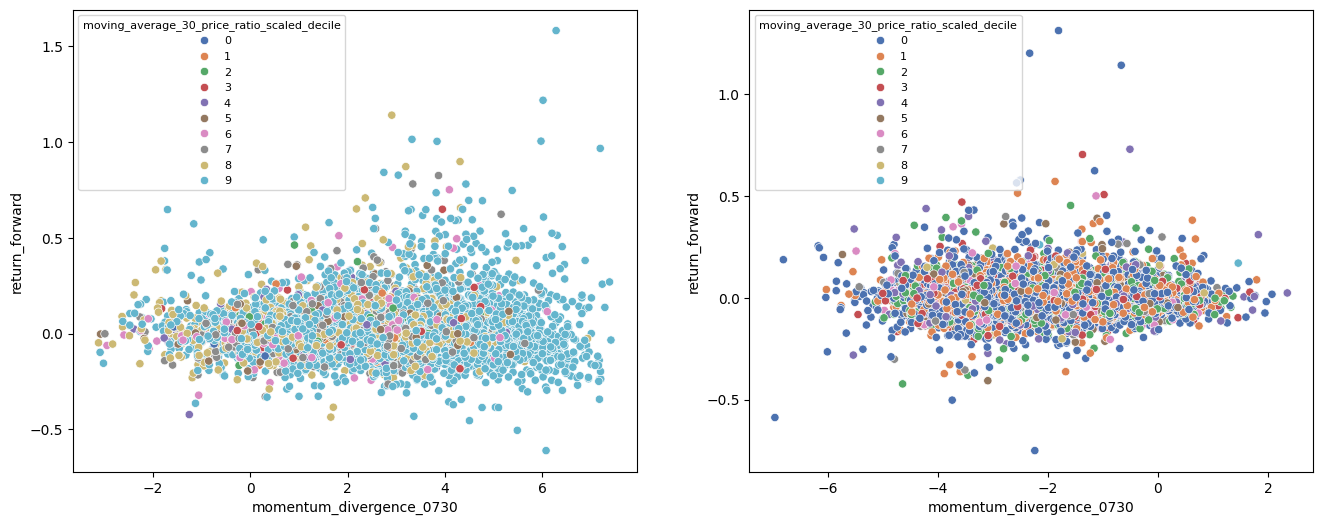

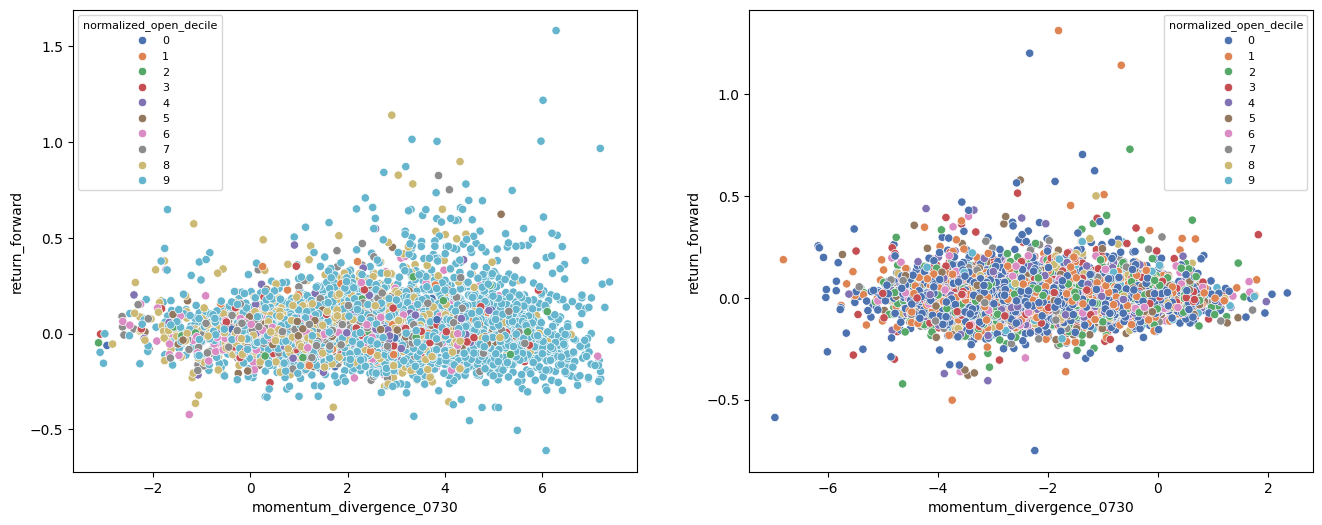

In [ ]:
add_features = ["moving_average_40_price_ratio_scaled_decile", "moving_average_30_price_ratio_scaled_decile", "normalized_open_decile"]
for category in add_features:
  fig, axs = plt.subplots(1,2, figsize=(16,6))

  (filter_df_and_plot_scatter(cross_df_universe, "momentum_divergence_0730",
                              "momentum_divergence_0730_decile", 9,
                              "return_forward", category,
                              axs[0]).legend(title=category, fontsize="8", title_fontsize="8"))

  (filter_df_and_plot_scatter(cross_df_universe, "momentum_divergence_0730",
                              "momentum_divergence_0730_decile", 0,
                              "return_forward", category,
                              axs[1]).legend(title=category, fontsize="8", title_fontsize="8"))

From the plots above there it is clear to see, that:
- no linear relationship exist between the z-scores and the forward return
- Terms like "if the z-score is high, the forward return is high" are not valid
- There are outliers in both deciles and explicitly in the top decile, the additional features cant capture negative returns when the z-score is high. For example the normalized_open_decile in the bottom left for the top decile: While the normalized open is in the top decile and the z-score is above 4, there are many negative returns visible. So this additional feature did not provide any value in terms like capturing negative returns while the z-score is high.

To get a clearer picture, seperate lm-plots are now shown. This means the plots are conditioned on the additional feature deciles.


In [ ]:
# LM-Plots from top/bottom deciles with categories
# Is there a clearer positive or negativ relationship per decile?
# Can outliers be capped?

def filtered_lm_plots(df, decile, main_feature_decile, main_feature_z, forward_return, category):

  filtered_df = df.loc[df[main_feature_decile] == decile]

  return sns.lmplot(data=filtered_df, x=main_feature_z, y=forward_return, col=category, height=5, aspect=1, col_wrap=5)

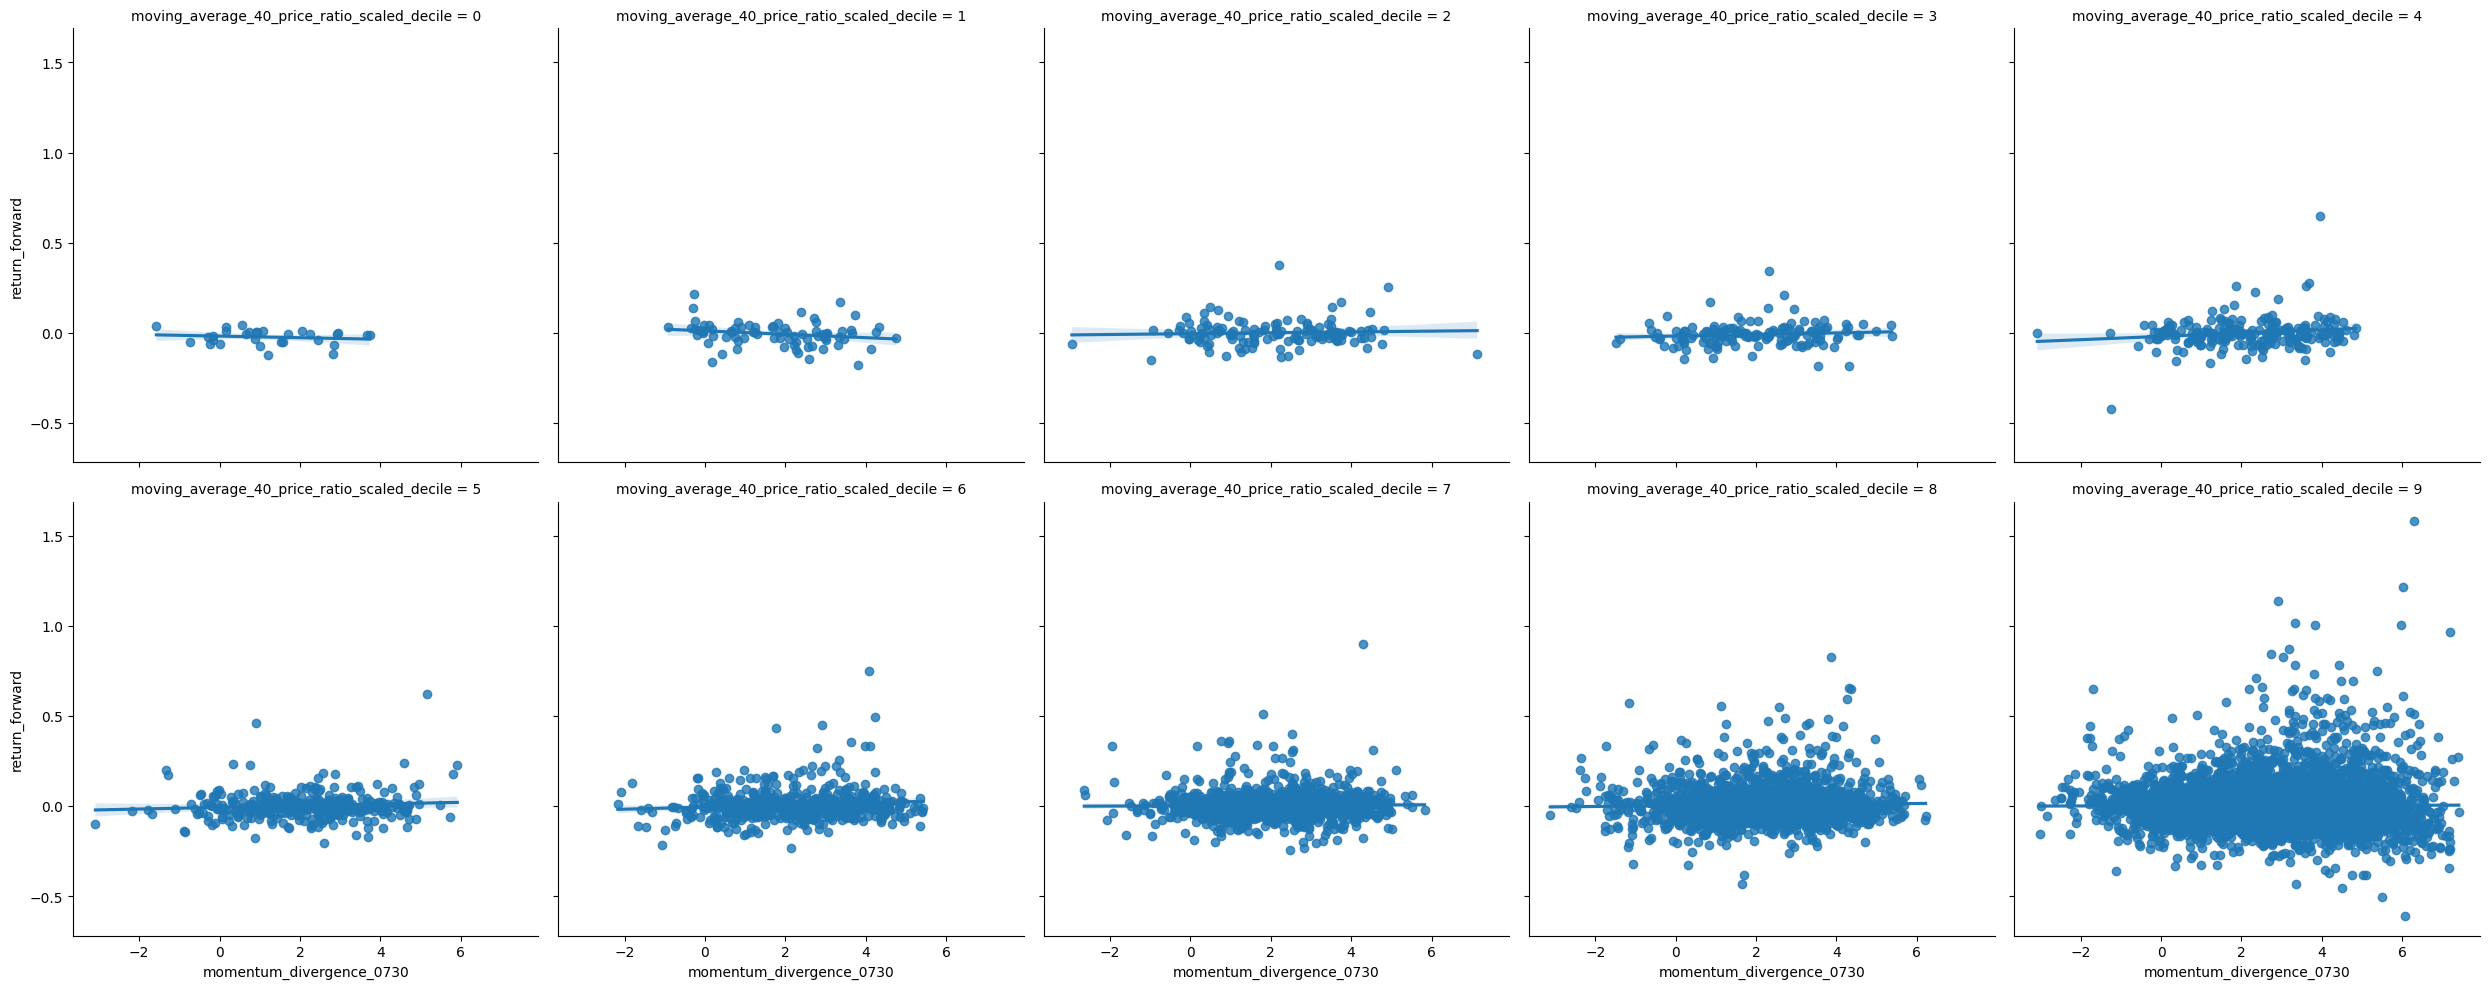

In [ ]:
# lmplots with the top decile and and the features from the scatter plots
add_features = ["moving_average_40_price_ratio_scaled_decile", "moving_average_30_price_ratio_scaled_decile", "normalized_open_decile"]

# First: Top Decile and "moving_average_40_price_ratio_scaled_decile"
(filtered_lm_plots(cross_df_universe, 9,
                   "momentum_divergence_0730_decile", "momentum_divergence_0730",
                   "return_forward", "moving_average_40_price_ratio_scaled_decile"))

Most of the datapoints are in the top decile from the ma_40_ratio feature. And as mentioned before, a clear linear relationship is not visible. This is valid for all deciles from the ma_40_ratio feature. The ma_30_ratio will not be plotted.

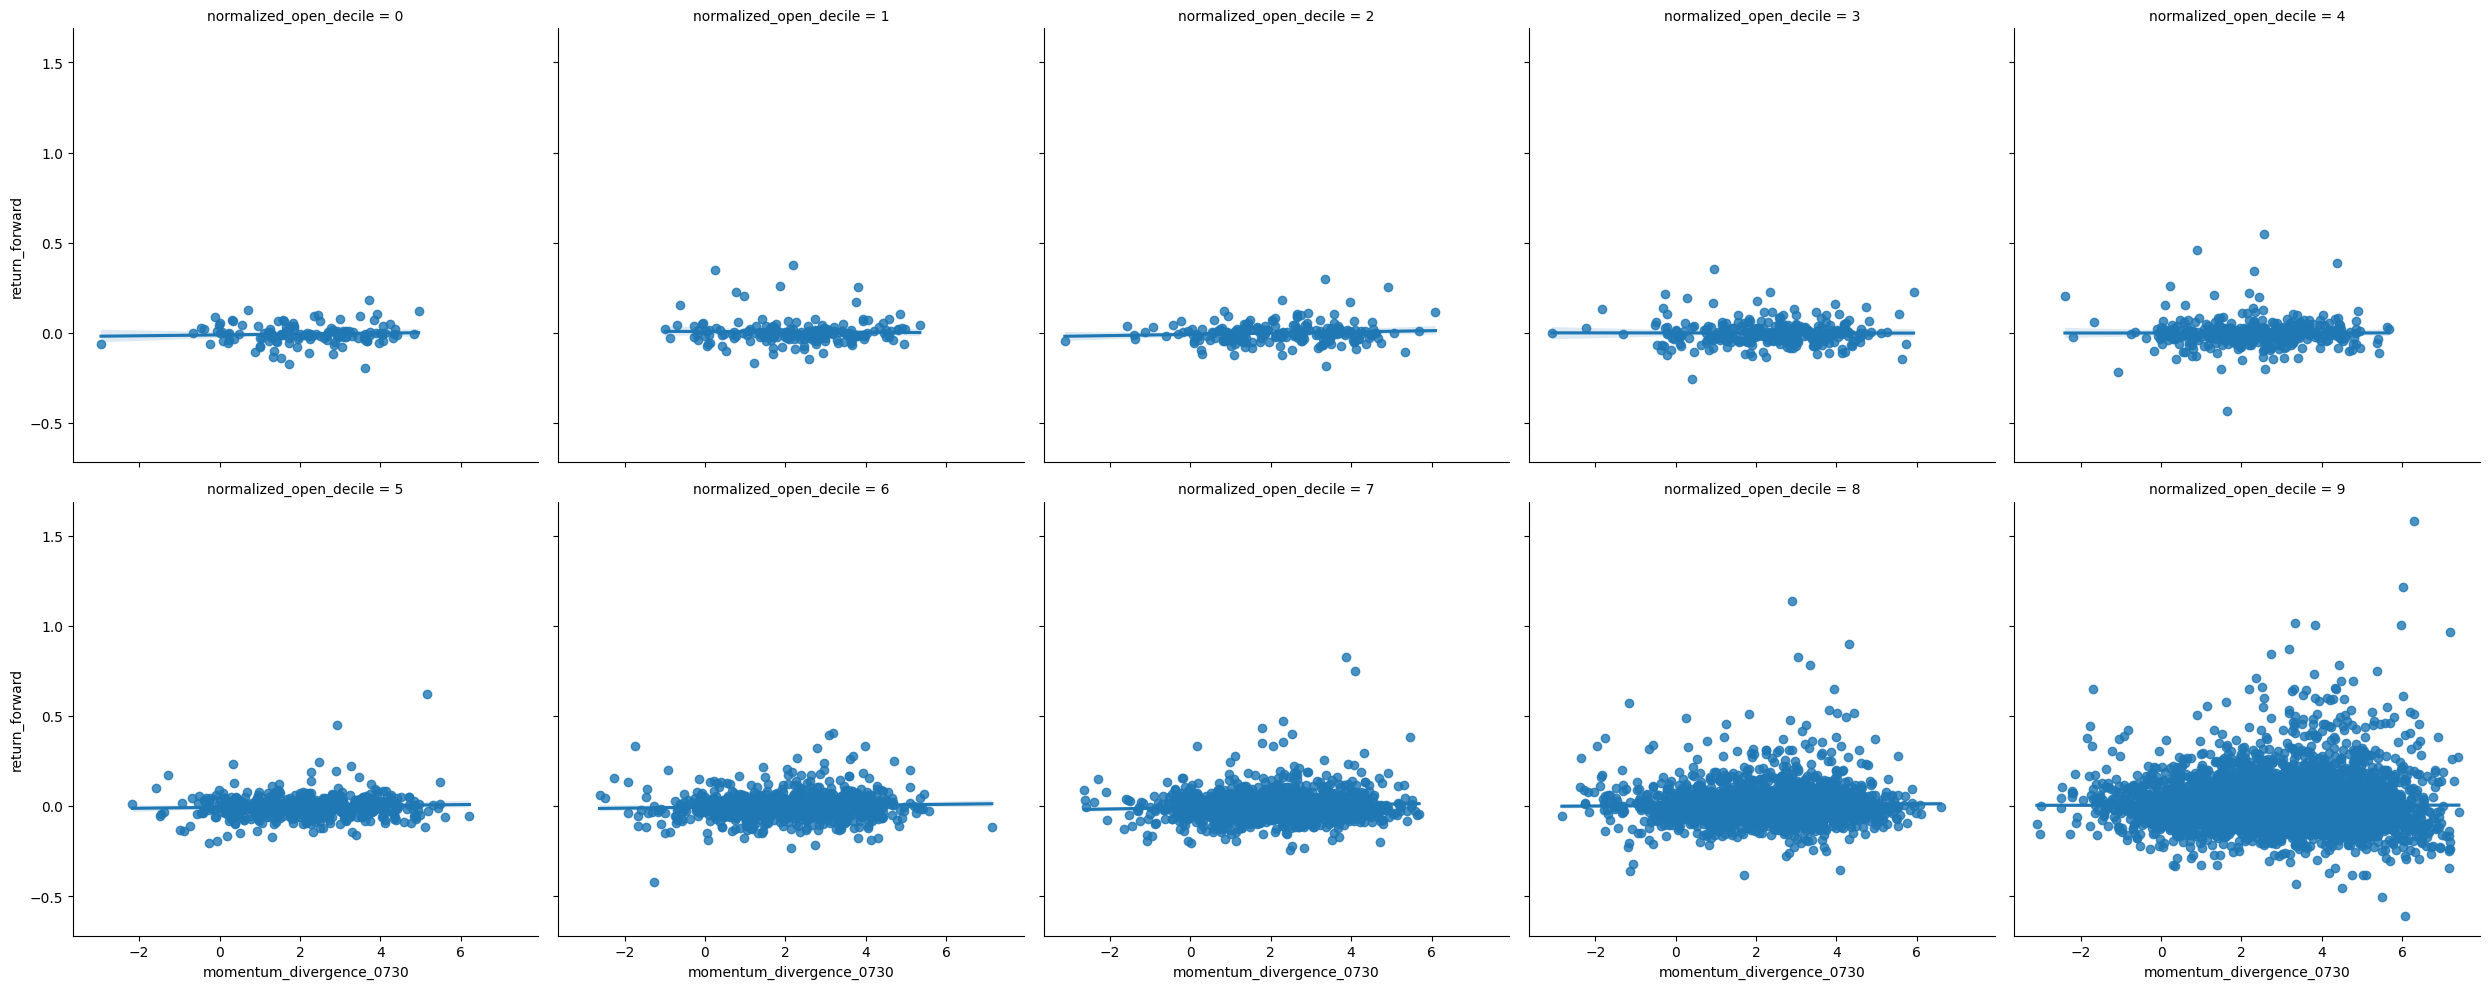

In [ ]:
# second: Top Decile and normalized_open_decile
(filtered_lm_plots(cross_df_universe, 9,
                   "momentum_divergence_0730_decile", "momentum_divergence_0730",
                   "return_forward", "normalized_open_decile"))

As with the "moving_average_40_price_ratio_scaled_decile" feature, the conditional lmplots for the normalized_open is showing a similar picture. Most of the datapoints are in the top decile from the normalized_open. Also no clear linear relationship is visible.

The bottom decile will now be shown for the same additional features.

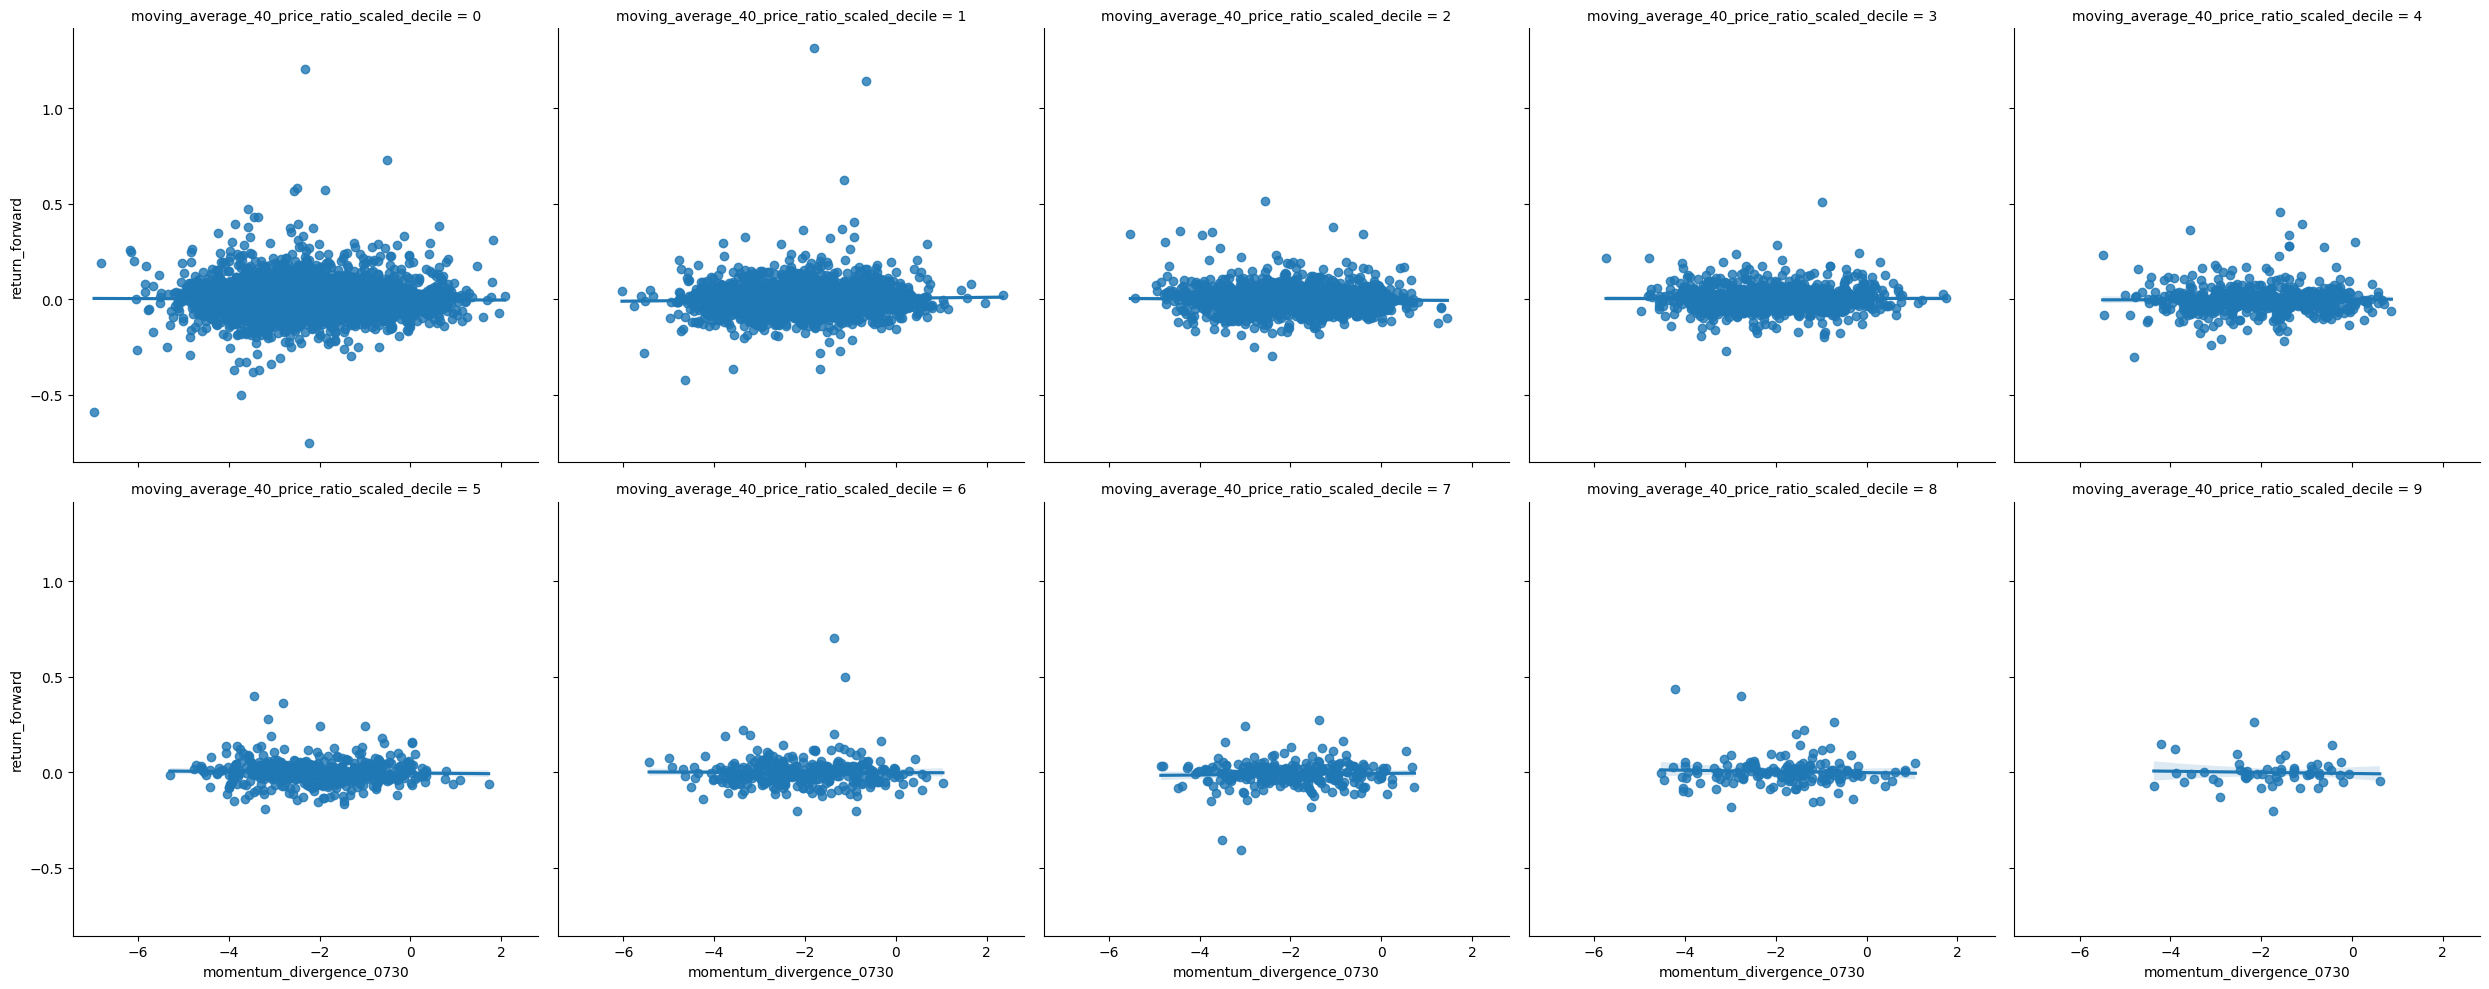

In [ ]:
# Now all the lmplots are presented for the bottom decile

# First: Bottom Decile and "moving_average_40_price_ratio_scaled_decile"
(filtered_lm_plots(cross_df_universe, 0,
                   "momentum_divergence_0730_decile", "momentum_divergence_0730",
                   "return_forward", "moving_average_40_price_ratio_scaled_decile"))

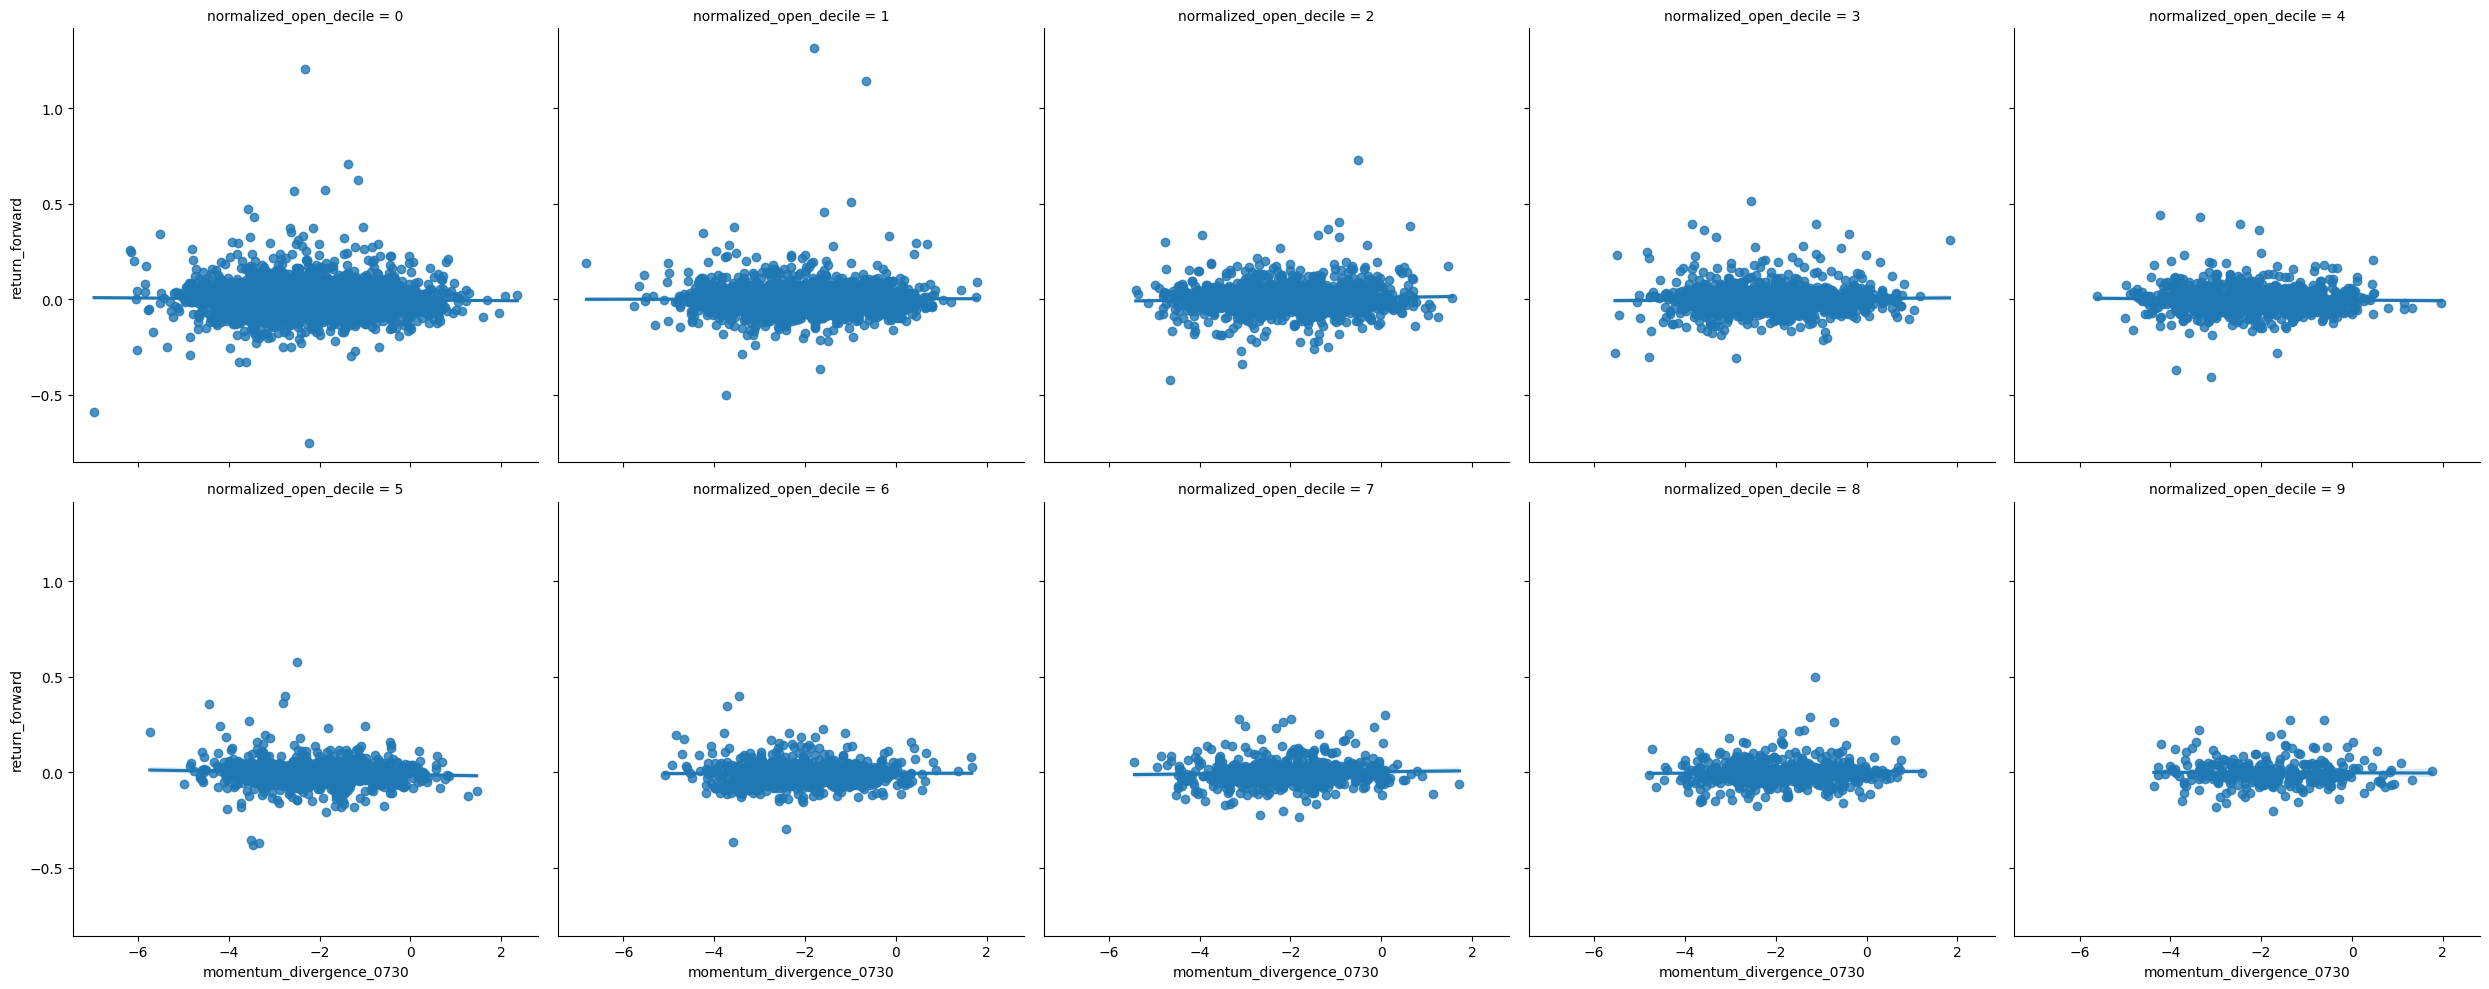

In [ ]:
# second: Bottom Decile and normalized_open_decile
(filtered_lm_plots(cross_df_universe, 0,
                   "momentum_divergence_0730_decile", "momentum_divergence_0730",
                   "return_forward", "normalized_open_decile"))

The interaction between the main feature and the additional feature has shown that a linear relationship is not observable. It is possible that a linear method is not valid to describe the relationship between the features and forward returns and non-linear methods are needed.

Also dimensionality reduction with PCA could be an another apporach to describe forward returns with principal components. PCA will not be applied here. This is a research approach for its own.

A next data analytical method for the features will be done now.
The average forward return for the top and bottom decile conditioned on the additional feature-decile are the next step in this analysis.

In [ ]:
# Plotting the average forward return from the top/bottom decile with an additionally
# feature
# This part is additionally to the previous lmplots

# Maybe it is usefull, only to buy the top decile, when an additional feature
# is also in the top decile.

# So the question is: is it possible to capture negative returns in the top decile
# and implement the feature which captured the negative returns in the strategy?

def conditional_bar_plot(df, main_feature_decile, main_feature, forward_return, category, ax):

  filtered_df = df.loc[df[main_feature] == main_feature_decile]

  return filtered_df.groupby(category)[forward_return].mean().plot(kind="bar", ax=ax)

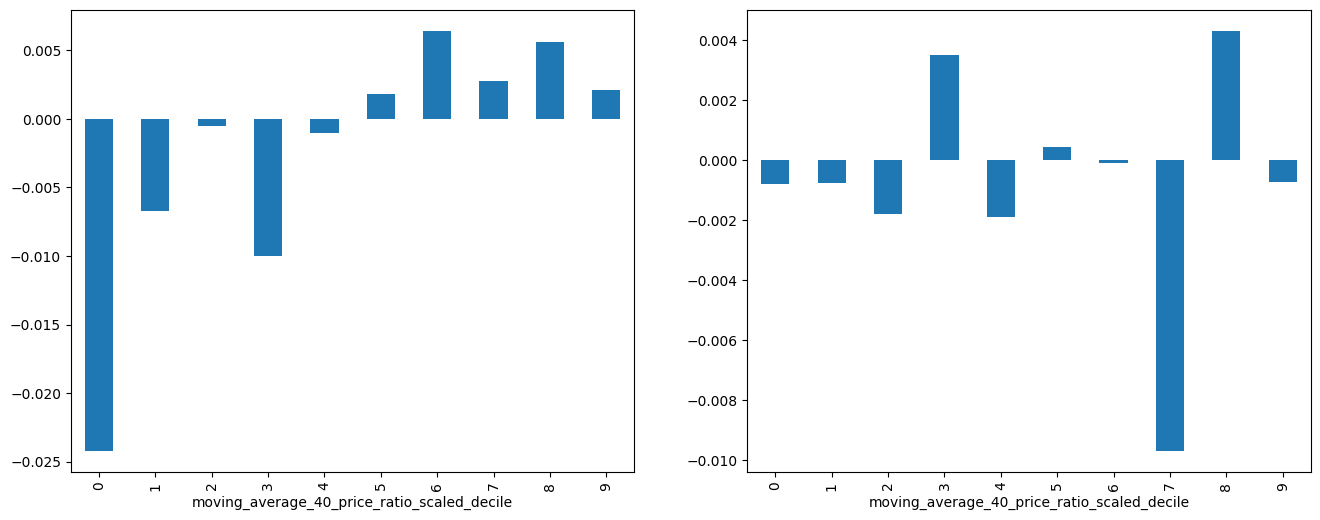

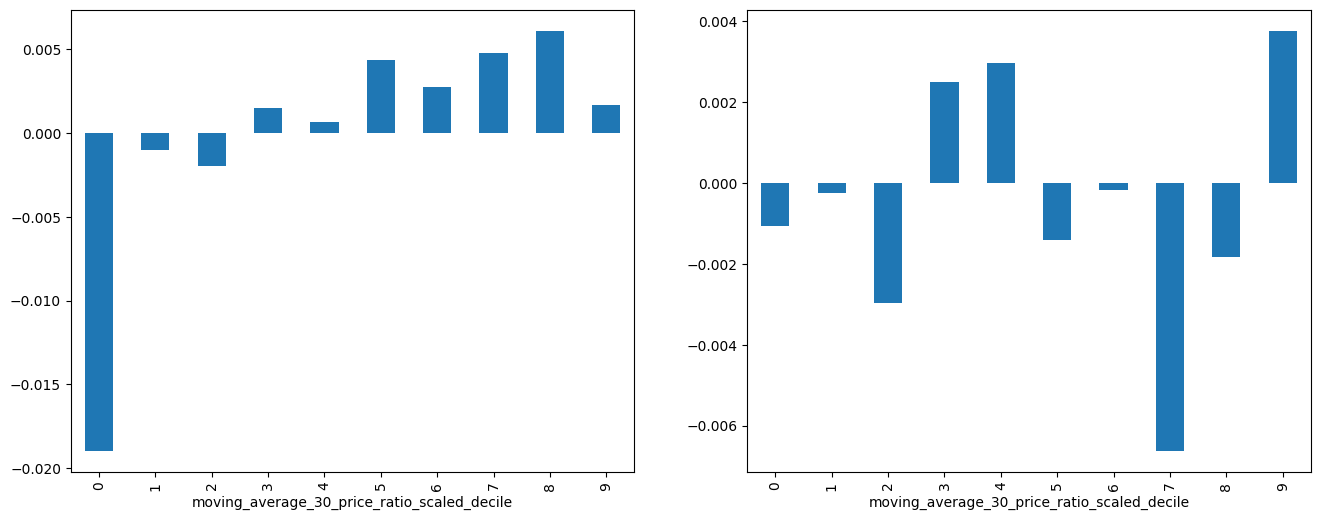

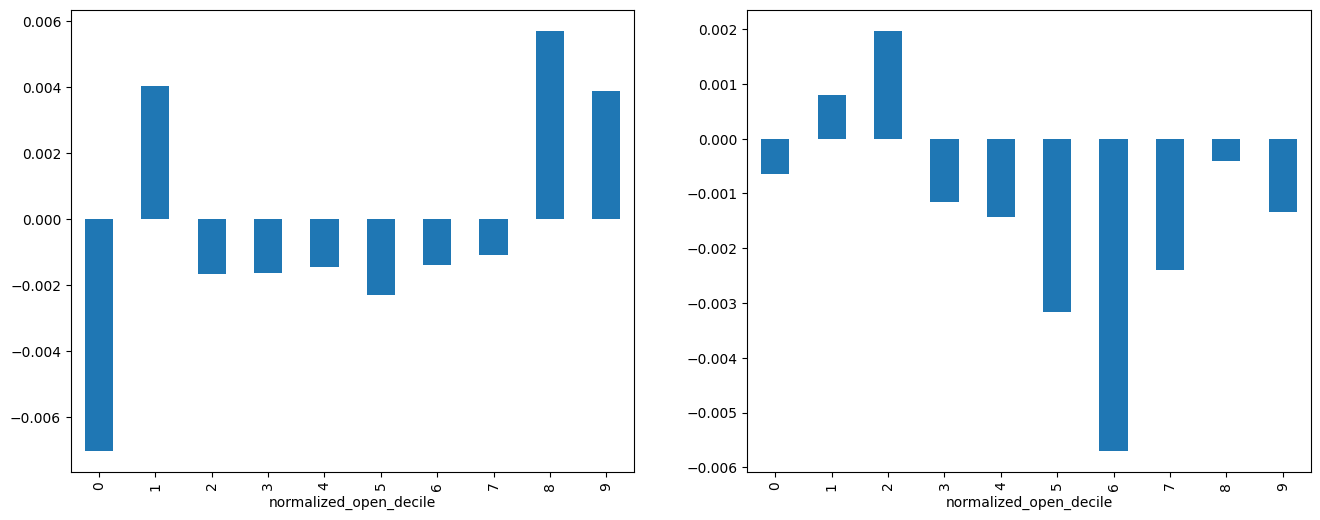

In [ ]:
add_features = ["moving_average_40_price_ratio_scaled_decile", "moving_average_30_price_ratio_scaled_decile", "normalized_open_decile"]

for category in add_features:
  fig, axs = plt.subplots(1,2, figsize=(16,6))

  conditional_bar_plot(cross_df_universe, 9, "momentum_divergence_0730_decile", "return_forward", category, axs[0])
  conditional_bar_plot(cross_df_universe, 0, "momentum_divergence_0730_decile", "return_forward", category, axs[1])

With my previous experience I would define some rules or thresholds. For example, the top left plot which represents the avg. forward returns from the top decile conditioned on the "moving_average_40_price_ratio_scaled_decile" feature: If the "moving_average_40_price_ratio_scaled_decile" is >= 5, I would implement this as a rule in the strategy and compare the results to the baseline strategy.

Other methods are necessary and a comparison from means with bootstrapping seems to be a valid approch. So as a result CHATGPT was my research assistant in this scenario, since my intuition was that a simple cumulative return comparison is ok but not the best solution.

For the bootstrapping part, the normalized_open_decile >= 8 and "moving_average_40_price_ratio_scaled_decile" >= 5 are choosen.

Bootstrapping or some rules for the bottom decile are not appropiate.
First, the top right and middle right plots are looking like there is some periodically pattern. This could be happen because of the "buy-the-dip" mentality. Second, if the normalized open for the top decile did not provide some value in terms of higher conditional expected returns, why it should provide some value for the bottom decile?

In [ ]:
# Function for the bootstrap.
# This function will be later also usefull

def bootstrap_mean_diff(df, main_feature, main_feature_decile, add_feature, add_feature_decile, forward_return, grouper, n_bootstrap):
  counter = 0
  boot_diffs = []

  group0 = df[df[main_feature] == main_feature_decile][forward_return].groupby(grouper).mean()
  group1 = df[(df[main_feature] == main_feature_decile) & (df[add_feature] >= add_feature_decile)][forward_return].groupby(grouper).mean()

  observed_diff = group1.mean() - group0.mean()

  for _ in range(n_bootstrap):
    subsample_1 = group1.sample(n=len(group1), replace=True)
    subsample_0 = group0.sample(n=len(group0), replace=True)

    boot_diffs.append(subsample_1.mean() - subsample_0.mean())

  for diff in boot_diffs:
    if abs(diff) >= abs(observed_diff):
      counter += 1

  lower = np.percentile(boot_diffs, 5)
  upper = np.percentile(boot_diffs, 95)
  p_value = counter / n_bootstrap

  return boot_diffs, {
      "observed_diff": observed_diff,
      "ci_5_95": (lower, upper),
      "p_value": p_value
  }

In [ ]:
# Call of the bootstrap fuction for the normalized_open_decile

boot_diffs_normalized_open, result_normalized_open = bootstrap_mean_diff(
    cross_df_universe,
    main_feature = "momentum_divergence_0730_decile",
    main_feature_decile=9,
    add_feature="normalized_open_decile",
    add_feature_decile=8,
    forward_return="return_forward",
    grouper="open_time",
    n_bootstrap=10000
)

print(result_normalized_open)

{'observed_diff': np.float64(0.0010421484706166378), 'ci_5_95': (np.float64(-0.002565663347278912), np.float64(0.004504887309849286)), 'p_value': 0.6746}


In [ ]:
# Call of the bootstrap fuction for the "scaled_ma_40_ratio_decile"

boot_diffs_ma_ratio, result_normalized_ma_ratio = bootstrap_mean_diff(
    cross_df_universe,
    main_feature = "momentum_divergence_0730_decile",
    main_feature_decile=9,
    add_feature="moving_average_40_price_ratio_scaled_decile",
    add_feature_decile=5,
    forward_return="return_forward",
    grouper="open_time",
    n_bootstrap=10000
)

print(result_normalized_ma_ratio)

{'observed_diff': np.float64(0.00013172485297141458), 'ci_5_95': (np.float64(-0.003250276534796402), np.float64(0.003553643303985718)), 'p_value': 0.9494}


H_0: There is no significant difference in the mean.
H_1: There is a significant difference in the mean.

H_0 cant be rejected for both features. So there is no need to test them in a strategy.

As a last analytical step, the z-scores themselves are analysed.
How is the return distribution, contioned on capped z-scores?

In Other words: "When the z-score is too high, the market is overheated and a sharp drop occurs". "When the z-score is too low, the market is in panic mode and the sell-off will persist".

Two approaches are done:
1. Capped z-scores
2. Ranged z-scores

In [ ]:
# Capping the z-score based on the scatterplots
# If applicable the forward returns or the market is overheated, when the
# z-score is too high in the top decile or too low in the bottom decile (mean reversion)
# The Average return based on this filtering should give an answer or a clue

# When the z-score is above 6 in the top decile, how does the returns behave under
# this condition?

def capped_z_and_mean(df, decile, main_feature_deciles, main_feature, forward_return):

  z_series = []
  z_values_above_zero = [0, 1, 2, 3, 4, 5, 5.5, 6]
  z_values_below_zero = [-6, -5, -4, -3, -2.5, -2, -1, -0.5]

  for z_negative in z_values_below_zero:

    z_mean = (df.loc[(df[main_feature_deciles] == decile) & (df[main_feature] <= z_negative)]
              .groupby(main_feature_deciles)[forward_return].mean())
    z_mean = z_mean.rename(f"avg_return_by_z_{z_negative}")

    z_series.append(z_mean)

  for z_positive in z_values_above_zero:

    z_mean = (df.loc[(df[main_feature_deciles] == decile) & (df[main_feature] >= z_positive)]
              .groupby(main_feature_deciles)[forward_return].mean())
    z_mean = z_mean.rename(f"avg_return_by_z_{z_positive}")

    z_series.append(z_mean)

  return z_series

<Axes: xlabel='momentum_divergence_0730_decile'>

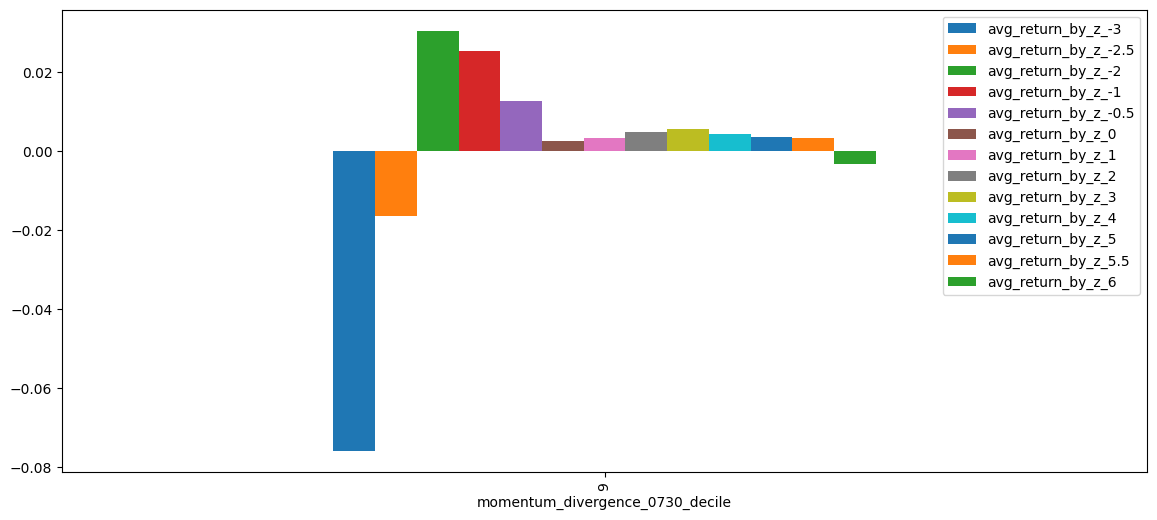

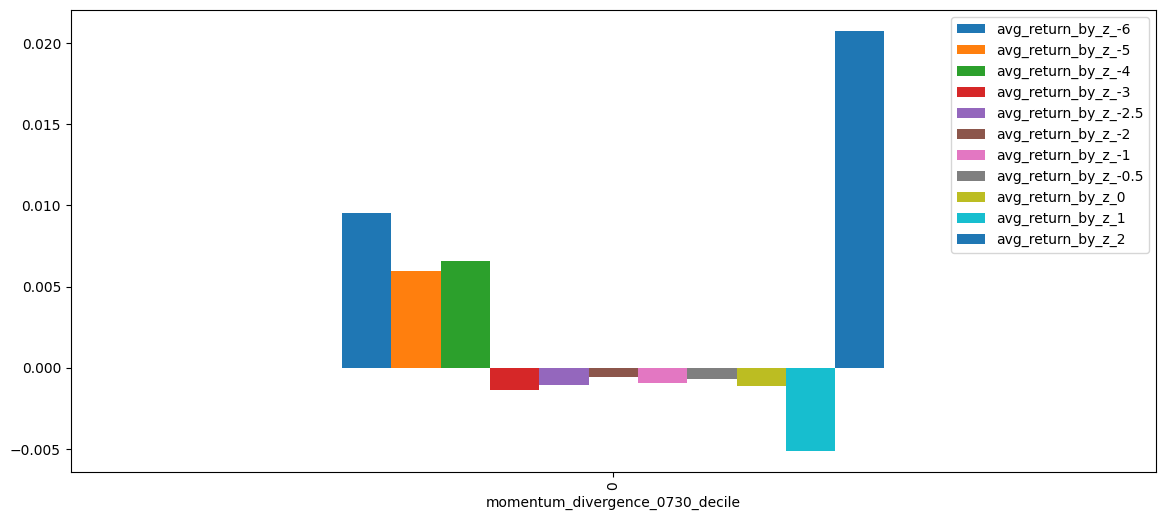

In [ ]:
# Call of the fuction capped_z_and_mean
top_capped_z = capped_z_and_mean(cross_df_universe, 9, "momentum_divergence_0730_decile", "momentum_divergence_0730", "return_forward")
bottom_capped_z = capped_z_and_mean(cross_df_universe, 0, "momentum_divergence_0730_decile", "momentum_divergence_0730", "return_forward")

pd.concat(top_capped_z, axis=1).dropna(axis=1).plot(kind="bar", figsize=(14,6))
pd.concat(bottom_capped_z, axis=1).dropna(axis=1).plot(kind="bar", figsize=(14,6))

Interestingly, for the top decile the greatest avg. forward returns are between -2 and -0.5. This is not as expected and looks like mean-reversion behavior. On the other hand, z-scores smaller than -2.5 show persistent behavior in terms of momentum for the short side.
Based on this plot, the avg. return with the baseline and a capped z-score with bootstrapping can be compared.

For the bottom decile, there is also some kind of mean-reversion behavior observable. Explicitly with z-scores smaller than -4. While a high z-score in the bottom decile shows momentum.

Maybe shorting the bottom decile is not a valid approach and a bet on mean-reversion is better?

In [ ]:
# Function for ranged z-scores and the corresponding avg. forward return

def ranged_z_and_mean(df, top_decile, bottom_decile, main_feature_deciles, main_feature, forward_return):

  z_pos, z_neg = [], []
  z_ranges_top = ([[-3.5, -3], [-3, -2.5], [-2.5, -2], [-2, -1], [-1, 0],
                  [0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 5.5], [5.5, 6], [6, 8]])

  z_ranges_bottom = ([[-8, -6], [-6, -5], [-5, -4], [-4, -3], [-3, -2], [-2, -1], [-1, 0],
                      [0, 0.5], [0.5, 1], [1, 1.5], [1.5, 2], [2, 2.5]])

  for z_top in z_ranges_top:

    z_mean = (df.loc[(df[main_feature_deciles] == top_decile) & (df[main_feature] >= z_top[0]) & (df[main_feature] <= z_top[1])]
              .groupby(main_feature_deciles)[forward_return].mean())
    z_mean = z_mean.rename(f"avg_return_between_z_{z_top[0]}_{z_top[1]}")

    z_pos.append(z_mean)

  for z_bot in z_ranges_bottom:

    z_mean = (df.loc[(df[main_feature_deciles] == bottom_decile) & (df[main_feature] >= z_bot[0]) & (df[main_feature] <= z_bot[1])]
              .groupby(main_feature_deciles)[forward_return].mean())
    z_mean = z_mean.rename(f"avg_return_between_z_{z_bot[0]}_{z_bot[1]}")

    z_neg.append(z_mean)

  return z_pos, z_neg

<Axes: xlabel='momentum_divergence_0730_decile'>

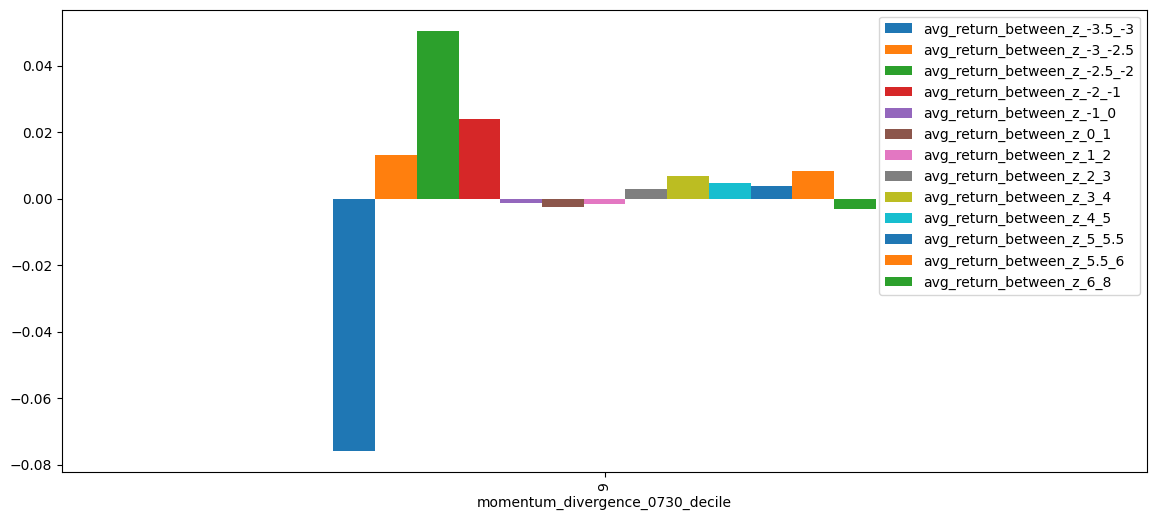

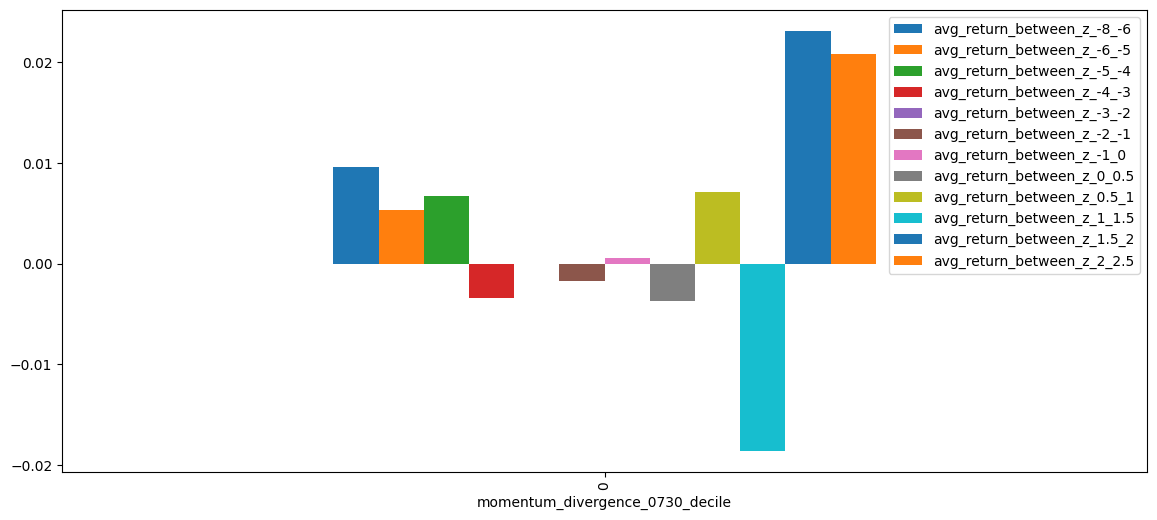

In [ ]:
# Call of the function ranged_z_and_mean
avg_rets_top_between_zs, avg_rets_bottom_between_zs = (ranged_z_and_mean(cross_df_universe, 9, 0,
                                                                         "momentum_divergence_0730_decile",
                                                                         "momentum_divergence_0730",
                                                                         "return_forward"))

pd.concat(avg_rets_top_between_zs, axis=1).plot(kind="bar", figsize=(14,6))
pd.concat(avg_rets_bottom_between_zs, axis=1).plot(kind="bar", figsize=(14,6))

This approach will be dropped (ranged z-scores).
Only based from both plots, there is not a big difference. Hence both plots are looking kind similar. And a rule based on something like "buy, when the z-scores is between -3 and -2 etc." sounds a bit like overfitting.

Lastly, the bootstrap for the capped z-score will be implemented. After this, some strategys will be tested with or without additional rules.



In [ ]:
# It seems that the bootstrap function can be directly used.
# There is no need to change the logic.
# add_feature will be mom_divergence_0730 and add_feature_decile will be z-score >= -2.5

def bootstrap_mean_diff(df, main_feature, main_feature_decile, add_feature, add_feature_decile, forward_return, grouper, n_bootstrap):
  counter = 0
  boot_diffs = []

  group0 = df[df[main_feature] == main_feature_decile][forward_return].groupby(grouper).mean()
  group1 = df[(df[main_feature] == main_feature_decile) & (df[add_feature] >= add_feature_decile)][forward_return].groupby(grouper).mean()

  observed_diff = group1.mean() - group0.mean()

  for _ in range(n_bootstrap):
    subsample_1 = group1.sample(n=len(group1), replace=True)
    subsample_0 = group0.sample(n=len(group0), replace=True)

    boot_diffs.append(subsample_1.mean() - subsample_0.mean())

  for diff in boot_diffs:
    if abs(diff) >= abs(observed_diff):
      counter += 1

  lower = np.percentile(boot_diffs, 5)
  upper = np.percentile(boot_diffs, 95)
  p_value = counter / n_bootstrap

  return boot_diffs, {
      "observed_diff": observed_diff,
      "ci_5_95": (lower, upper),
      "p_value": p_value
  }

In [ ]:
# Call of the bootstrap fuction for the capped z-scores

boot_diffs_capped_z, result_normalized_capped_z = bootstrap_mean_diff(
    cross_df_universe,
    main_feature = "momentum_divergence_0730_decile",
    main_feature_decile=9,
    add_feature="momentum_divergence_0730",
    add_feature_decile=-2.5,
    forward_return="return_forward",
    grouper="open_time",
    n_bootstrap=10000
)

print(result_normalized_capped_z)

{'observed_diff': np.float64(-7.307959867774907e-06), 'ci_5_95': (np.float64(-0.0033568004005905673), np.float64(0.0033588403162739507)), 'p_value': 0.9971}


H0 cant be rejected. Capping the z-score provides no significant difference in the forward mean return.

Maybe the step should be changed.
First, filtering based on a z-score value, then cross-sectional binning.

Last but not least, the strategy returns for the market neutral cross-sectional momentum strategy.

In [ ]:
# Cumulative forward returns from the top and bottom decile

# This is not a backtest

def plot_cumulative_returns_and_dd(df, main_feature, top_decile, bottom_decile, grouper, forward_return):

  top = df[df[main_feature] == top_decile].groupby(grouper)[forward_return].mean()
  bottom = df[df[main_feature] == bottom_decile].groupby(grouper)[forward_return].mean()

  top = top.rename("return_forward_top_mean")
  bottom = bottom.rename("return_forward_bottom_mean")

  returns = top-bottom

  cumu_max = (1 + returns).cumprod().cummax()
  drawdown = ((1 + returns).cumprod() - cumu_max) / cumu_max

  fig, axs = plt.subplots(2, figsize=(14,8))

  axs[0].plot((1 + returns).cumprod())
  axs[1].plot(drawdown)


  return plt.show()


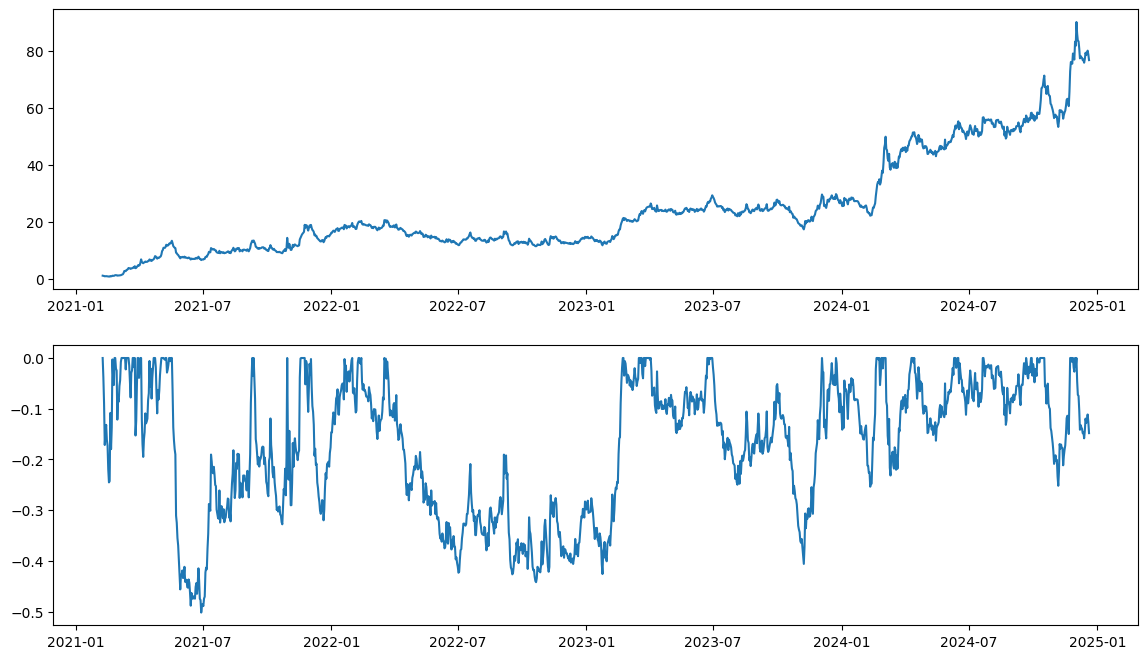

In [ ]:
# Cumulative returns without filtering ("raw")

plot_cumulative_returns_and_dd(cross_df_universe, "momentum_divergence_0730_decile", 9, 0, "open_time", "return_forward")

While the Strategy seems to be profitable on paper, several aspects are not addressed:
1. Shorting spot is not that easy. So the bottom decile cant be traded directly. One solution could be to short coins, which are available at margin mode. So this is a problem on its own.
2. Shorting the future could also be done. But like before, the explicit coin as a future must be present. And, of course, the same history like the spot will be needed for a valid analysis and backtest.
3. Implement directly a hedging strategy with futures. Since the short leg functions as a hedge because the bottom decile is not profitable.
4. Transaction costs and slippage are not implemented. This will reduce the overall performance.
5. The volatility from the performance is very high. Yes, the strategy is profitable, but it really looks like a roller coaster for the emotions "up, down, range, up, range, down, up". Do you really want to trade this volatility?
6. Is a long only strategy tradeble?

The seperate performance for the top and bottom will be shown. The performance from the top decile is from big interest.

In [ ]:
# Function, to get the top and bottom returns

def get_top_bottom_returns(df, main_feature, top_decile, bottom_decile, grouper, forward_return):

  top = df[df[main_feature] == top_decile].groupby(grouper)[forward_return].mean()
  bottom = df[df[main_feature] == bottom_decile].groupby(grouper)[forward_return].mean()

  top = top.rename("return_forward_top_mean")
  bottom = bottom.rename("return_forward_bottom_mean")

  return top, bottom

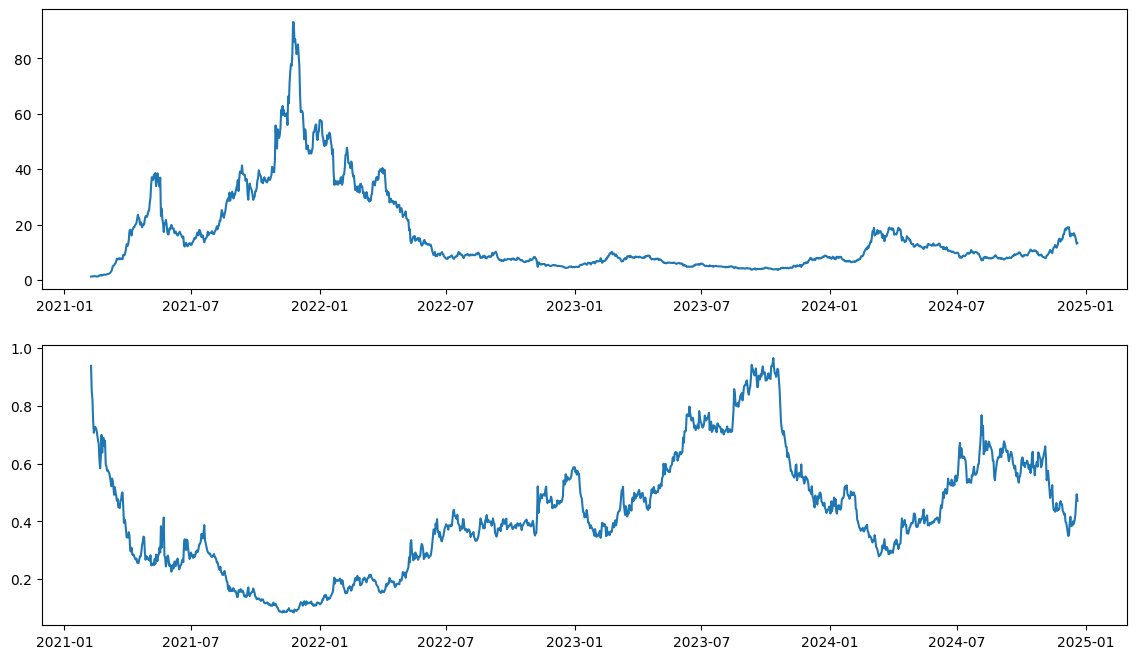

In [ ]:
# Cumulative returns for both deciles
top_df, bottom_df = get_top_bottom_returns(cross_df_universe, "momentum_divergence_0730_decile", 9, 0, "open_time", "return_forward")

fig, axs = plt.subplots(2, figsize=(14,8))

axs[0].plot((1 + top_df).cumprod())
axs[1].plot((1 - bottom_df).cumprod())

As mentioned before, the short leg is not profitable and works only as a hedge during bear markets. It is evident, that the short leg was most profitable during 2022 till mid 2023. The long leg can not be traded like that. The Drawdown is too bad. Most of the proftis are gone.

This is typical crypto behavior, where trends are mostly dominated by short term movements. Trends are not stable. So the long leg can only be traded with a regime filter, a hedging strategy or a short term holding period.

To come to an end in this research notebook, the last part consists of the following steps:

1. Define a regime filter
2. Scatterplot with the regime filter
3. Strategy returns with regime filter before costs
4. Summary

<Axes: xlabel='open_time'>

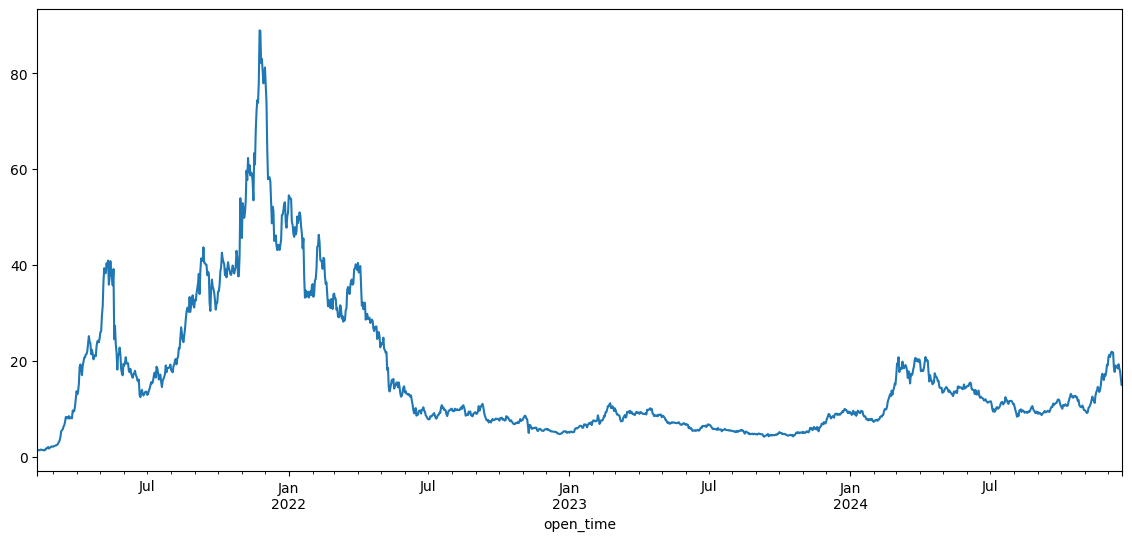

In [ ]:
# Just for fun, only to check that an additional feature really not provide any value

((cross_df_universe[(cross_df_universe["momentum_divergence_0730_decile"] == 9)
 & (cross_df_universe["moving_average_40_price_ratio_scaled_decile"] >= 5)].
 groupby("open_time")["return_forward"].
 mean() + 1).cumprod().
 plot(kind="line", figsize=(14,6)))

Classical regime filter involes something like moving averages. The following idea comes from de Prado (2018). de Prado presented the "cusum-filter". The following regime filter consists of the cumulative sum from the average universe return.

The idea is simple: "Buying is allowed, when the cumulative sum from the average universe return crosses a simple threshold. Otherwise flat".

To avoid look-ahead bias, universe cumsums are calculated on a monthly basis.

This is not the cusum-filter as described in de Prado (2018).

In [ ]:
# Monthly Cumsums as a market regime filter from the top 100 universe itself
years = [2021, 2022, 2023, 2024]
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
monthly_cusums = []

for year in years:
  for month in months:
    cusu = (cross_df_universe.loc[f"{year}-{month}"].groupby("open_time")["return"].mean().cumsum())
    monthly_cusums.append(cusu)


In [ ]:
# Stacked DF with regime filter

cusums_monthly = pd.concat(monthly_cusums)
cusums_monthly.rename("cusums_monthly")

cross_df_universe["cusums_monthly"] = cusums_monthly
cross_df_universe["market_regime"] = "bear"
cross_df_universe["market_regime"] = np.where(cross_df_universe["cusums_monthly"] >= 0, "bull", cross_df_universe["market_regime"])
cross_df_universe["market_regime_2"] = "bear"
cross_df_universe["market_regime_2"] = np.where(cross_df_universe["cusums_monthly"] >= 0.05, "bull", cross_df_universe["market_regime_2"])


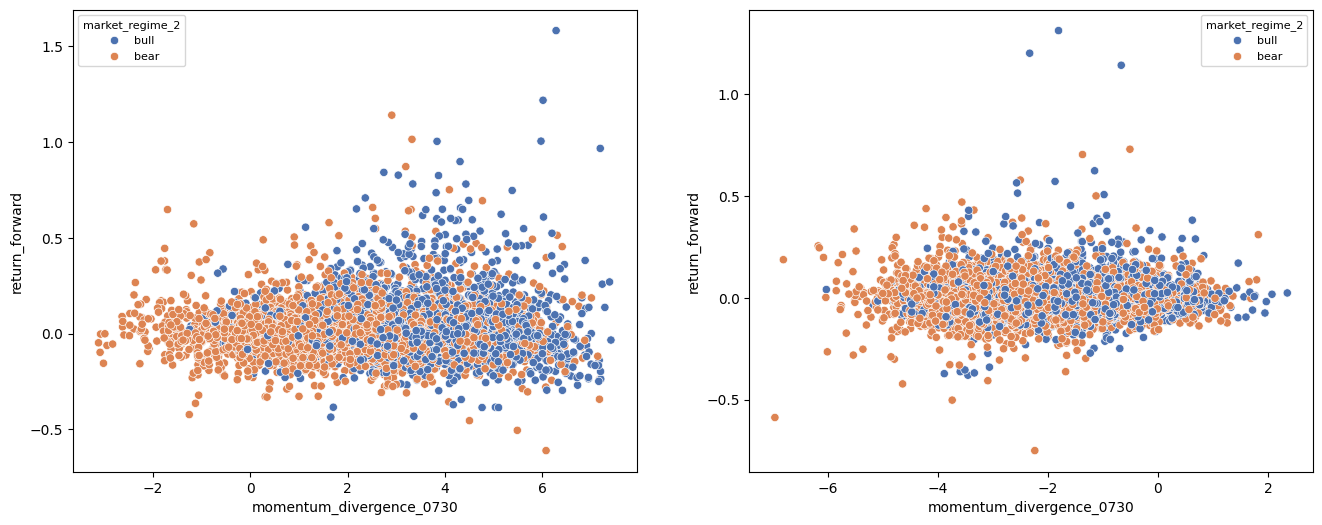

In [ ]:
# Top and Bottom Decile, Scatter with market regime filter
# Is there a better discrimination in the returns with the regime filter?

fig, axs = plt.subplots(1, 2, figsize=(16,6))

(filter_df_and_plot_scatter(cross_df_universe, "momentum_divergence_0730",
                            "momentum_divergence_0730_decile", 9,
                            "return_forward", "market_regime_2",
                            axs[0]).legend(title="market_regime_2", fontsize="8", title_fontsize="8"))

(filter_df_and_plot_scatter(cross_df_universe, "momentum_divergence_0730",
                            "momentum_divergence_0730_decile", 0,
                            "return_forward", "market_regime_2",
                            axs[1]).legend(title="market_regime_2", fontsize="8", title_fontsize="8"))

With the regime filter, some outliers with high negative returns and a high z-score are now captured. This is exactly the behavior as wanted. On the other side, many positive returns are also in the bear regime. As the last part for this notebook, the regime filter will be implemented in the strategy.

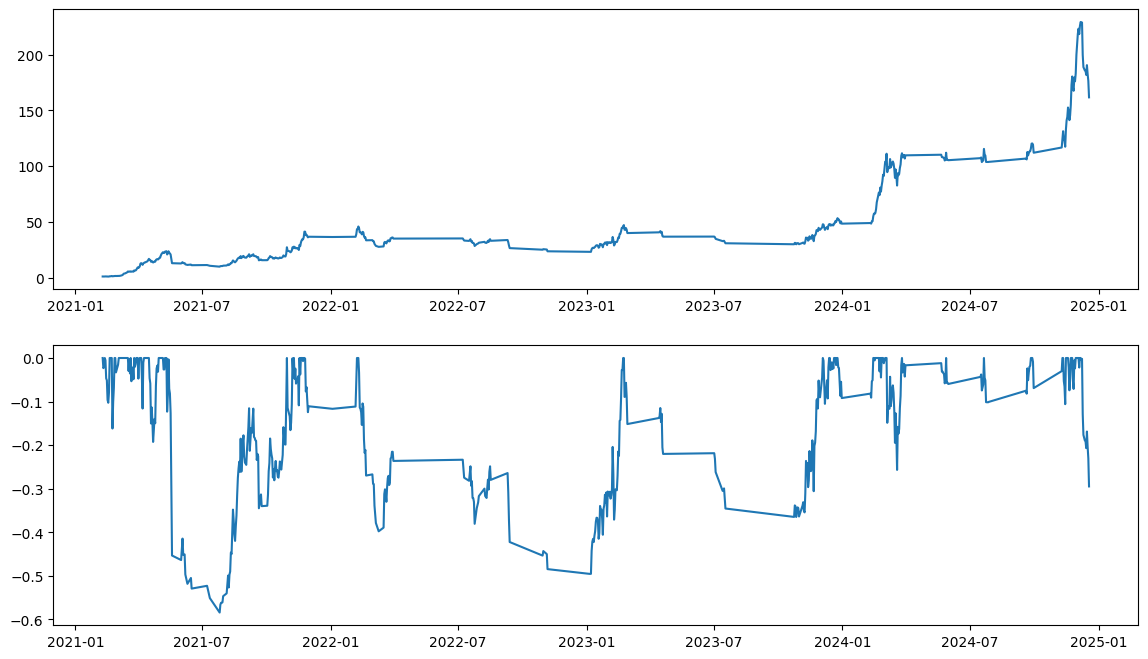

In [ ]:
# cumulative product from the returns
filtered_rets = (cross_df_universe.loc[(cross_df_universe["momentum_divergence_0730_decile"] == 9)
                  & (cross_df_universe["market_regime_2"] == "bull")]
                 .groupby("open_time")["return_forward"].mean())
cumulative_returns = (1 + filtered_rets).cumprod()

cumu_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - cumu_max) / cumu_max

fig, axs = plt.subplots(2, figsize=(14,8))

axs[0].plot(cumulative_returns)
axs[1].plot(drawdown)

# Summary

Without any additional tests, the long only variant with the regime filter is, of course, profitable. But the filter seems to be to restrictive. Many trades or returns are gone and the drawdown with duration and magnitude looks like the cross-sectional baseline. So while the performance improved, the drawdown is still the same compared to the cross-sectional baseline, but better than the long-only variant.

From my personal point of view, the filter is ok in terms of getting higher returns, but I think there are other methods or solutions, which can be tested.

For example, Hidden Markov Models (HMMs) for the universe returns and position sizing based on the given probability for the current timestep. Other methods like position sizing with inverse volatility can also be done.

On the other side, volatility based positions needs to be tested. Criticism for this method exists and is qualitatively valid. When the market drops sharp, it really doenst matter if positions are based on volatility. Positions with high exposure because of low volatility can also bring bad drawdowns.

Personally, I will trade this strategy live. But before a deployment will be done, my main goal is to model the Market with a HMM. And the most important part: Out-of-sample test and permutations with Monte Carlo Simulations.

If you came this far, thank you for reading.
I hope you enjoyed the classical data analysis approach.
